In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
FOLD=1

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *
from efficientnet_pytorch import EfficientNet
from fastaudio.augment.spectrogram import CropTime

In [5]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
seed_everything(1234)

In [6]:
path = Path("/home/kkalyan/agri-split/data")

In [7]:
(path/"audio_files").ls()

(#2126) [Path('/home/kkalyan/agri-split/data/audio_files/BK8UDCM.wav'),Path('/home/kkalyan/agri-split/data/audio_files/3B5A2P3.wav'),Path('/home/kkalyan/agri-split/data/audio_files/7QXN2WO.wav'),Path('/home/kkalyan/agri-split/data/audio_files/E04FSN7.wav'),Path('/home/kkalyan/agri-split/data/audio_files/O0L4PC1.wav'),Path('/home/kkalyan/agri-split/data/audio_files/0TYHMIF.wav'),Path('/home/kkalyan/agri-split/data/audio_files/48PTKS5.wav'),Path('/home/kkalyan/agri-split/data/audio_files/J28NE2C.wav'),Path('/home/kkalyan/agri-split/data/audio_files/3J8WKXR.wav'),Path('/home/kkalyan/agri-split/data/audio_files/67FIJLB.wav')...]

In [8]:
df = pd.read_csv(path/"Train_v.csv")
df.head()

,fn,label,fold
0,audio_files/IV38R7F.wav,akawuka,1
1,audio_files/KM4SKWT.wav,banana,1
2,audio_files/F5POSU9.wav,obulwadde,3
3,audio_files/MMVDXG2.wav,nnyaanya,1
4,audio_files/9TVM96F.wav,pampu,1


In [9]:
ct = CropTime(duration=1000)
cfg = AudioConfig.BasicMelSpectrogram(n_fft=512)
a2s = AudioToSpec.from_cfg(cfg)

In [10]:
def CrossValidationSplitter(col='fold', fold=1):
    "Split `items` (supposed to be a dataframe) by fold in `col`"
    def _inner(o):
        assert isinstance(o, pd.DataFrame), "ColSplitter only works when your items are a pandas DataFrame"
        col_values = o.iloc[:,col] if isinstance(col, int) else o[col]
        valid_idx = (col_values == fold).values.astype('bool')
        return IndexSplitter(mask2idxs(valid_idx))(o)
    return _inner

In [11]:
auds = DataBlock(blocks=(AudioBlock, CategoryBlock), 
                 get_x=ColReader("fn", pref=path), 
                 batch_tfms = [a2s],
                 splitter=CrossValidationSplitter(fold=FOLD),
                 item_tfms=[ResizeSignal(3000), SignalShifter(), AddNoise(), ChangeVolume(), SignalLoss()],
                 get_y=ColReader("label"))

In [12]:
dbunch = auds.dataloaders(df, bs=128)

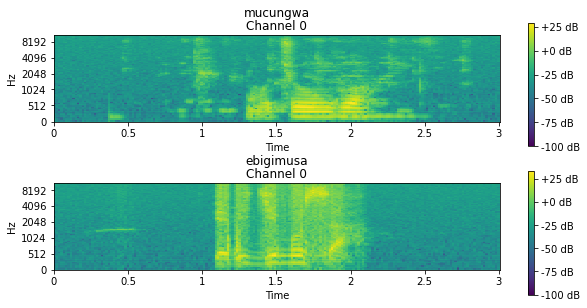

In [13]:
dbunch.show_batch(figsize=(10, 5))

In [14]:
learn = cnn_learner(dbunch, 
            alexnet, 
            config=cnn_config(n_in=1),
            loss_fn=LabelSmoothingCrossEntropy,
            metrics=[accuracy]).to_fp16()

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /home/kkalyan/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [15]:
x,y = next(iter(learn.dls.train))

In [16]:
x.shape

torch.Size([128, 1, 128, 188])

In [17]:
learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy,time
0,7.069304,7.135569,0.002703,00:02


epoch,train_loss,valid_loss,accuracy,time
0,7.115518,6.078565,0.010811,00:02
1,7.087284,5.758937,0.013514,00:02
2,7.066114,5.743256,0.008108,00:02
3,6.995115,5.682999,0.000000,00:02
4,6.882789,5.490071,0.013514,00:02
5,6.784899,5.421649,0.005405,00:02
6,6.701497,5.473366,0.008108,00:03
7,6.605355,5.434887,0.013514,00:03
8,6.529596,5.767290,0.013514,00:02
9,6.459466,5.614558,0.010811,00:02


In [18]:
learn.fit_one_cycle(150, 1e-3, cbs=[EarlyStoppingCallback(patience=20), SaveModelCallback(fname='save-nb-{}'.format(FOLD))])

epoch,train_loss,valid_loss,accuracy,time
0,6.034791,5.918486,0.005405,00:03
1,6.079753,5.730857,0.008108,00:03
2,6.059193,5.886466,0.021622,00:03
3,6.038470,6.611794,0.008108,00:03
4,6.054852,6.513672,0.010811,00:03
5,6.037414,6.464069,0.016216,00:03
6,6.026736,8.047979,0.018919,00:03
7,6.023612,6.401803,0.021622,00:03
8,5.991290,6.055320,0.013514,00:03
9,5.975998,5.817766,0.037838,00:04


Better model found at epoch 0 with valid_loss value: 5.918485641479492.
Better model found at epoch 1 with valid_loss value: 5.7308573722839355.
Better model found at epoch 17 with valid_loss value: 5.62449312210083.
Better model found at epoch 36 with valid_loss value: 5.268861770629883.
Better model found at epoch 38 with valid_loss value: 4.98735237121582.
Better model found at epoch 50 with valid_loss value: 4.525794506072998.
Better model found at epoch 51 with valid_loss value: 4.461119174957275.
Better model found at epoch 56 with valid_loss value: 4.353245258331299.
Better model found at epoch 57 with valid_loss value: 4.095000267028809.
Better model found at epoch 59 with valid_loss value: 4.092706680297852.
Better model found at epoch 63 with valid_loss value: 4.042453765869141.
Better model found at epoch 64 with valid_loss value: 4.0038018226623535.
Better model found at epoch 66 with valid_loss value: 3.94555926322937.
Better model found at epoch 70 with valid_loss value: 

In [19]:
learn.load('save-nb-{}'.format(FOLD))

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=0.02754228748381138)

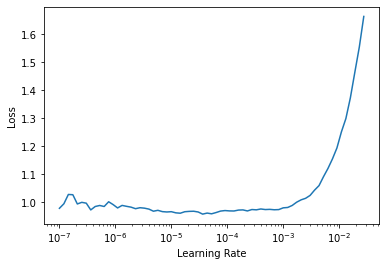

In [20]:
learn.unfreeze()
learn.lr_find(suggestions=True)

In [21]:
learn.fit_one_cycle(150, slice(1e-5, 1e-3), cbs=[EarlyStoppingCallback(patience=20), 
                                                 SaveModelCallback(fname='save-nb-{}'.format(FOLD))])

epoch,train_loss,valid_loss,accuracy,time
0,1.013897,3.467253,0.348649,00:03
1,0.994504,3.285979,0.337838,00:04
2,0.967049,3.284009,0.324324,00:03
3,0.983343,3.277623,0.343243,00:03
4,0.985760,3.274846,0.329730,00:03
5,0.979637,3.261892,0.343243,00:03
6,0.976655,3.265265,0.348649,00:03
7,0.982237,3.464629,0.343243,00:04
8,0.980166,3.337121,0.348649,00:03
9,0.987959,3.317415,0.327027,00:03


Better model found at epoch 0 with valid_loss value: 3.4672532081604004.
Better model found at epoch 1 with valid_loss value: 3.2859790325164795.
Better model found at epoch 2 with valid_loss value: 3.2840092182159424.
Better model found at epoch 3 with valid_loss value: 3.277623176574707.
Better model found at epoch 4 with valid_loss value: 3.274845600128174.
Better model found at epoch 5 with valid_loss value: 3.261892318725586.
Better model found at epoch 15 with valid_loss value: 3.2305917739868164.
No improvement since epoch 15: early stopping


SuggestedLRs(lr_min=0.001096478197723627, lr_steep=7.585775847473997e-07)

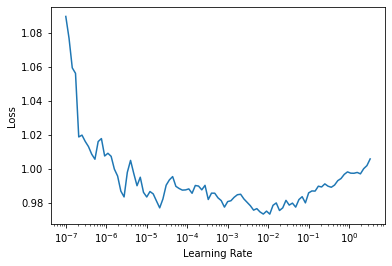

In [22]:
learn.lr_find(suggestions=True)

In [23]:
learn.load('save-nb-{}'.format(FOLD))

In [24]:
learn.fit_one_cycle(150, slice(4e-7, 1e-5), cbs=[EarlyStoppingCallback(patience=20), 
                                                 SaveModelCallback(fname='save-nb-{}'.format(FOLD))])

epoch,train_loss,valid_loss,accuracy,time
0,0.975257,3.314088,0.340541,00:03
1,0.962445,3.318840,0.329730,00:03
2,0.973144,3.272494,0.335135,00:03
3,0.975283,3.253404,0.351351,00:03
4,0.972581,3.252532,0.340541,00:03
5,0.974372,3.929978,0.327027,00:03
6,0.983367,4.224956,0.329730,00:03
7,0.984643,3.281810,0.337838,00:03
8,0.980799,3.256587,0.348649,00:03
9,0.976427,3.263293,0.354054,00:03


Better model found at epoch 0 with valid_loss value: 3.3140883445739746.
Better model found at epoch 2 with valid_loss value: 3.272494316101074.
Better model found at epoch 3 with valid_loss value: 3.253403663635254.
Better model found at epoch 4 with valid_loss value: 3.2525322437286377.
Better model found at epoch 13 with valid_loss value: 3.242750406265259.
Better model found at epoch 24 with valid_loss value: 3.2255446910858154.
No improvement since epoch 24: early stopping


SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=7.585775847473997e-07)

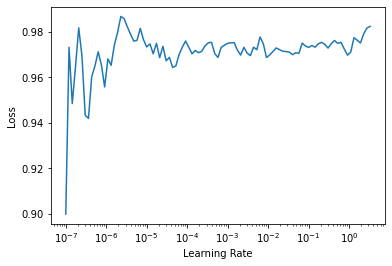

In [25]:
learn.lr_find(suggestions=True)

In [26]:
learn.load('save-nb-{}'.format(FOLD))

In [27]:
learn.fit_one_cycle(150, slice(1e-8, 1e-6), cbs=[EarlyStoppingCallback(patience=20), 
                                                 SaveModelCallback(fname='save-nb-{}'.format(FOLD))])

epoch,train_loss,valid_loss,accuracy,time
0,0.997845,8.652080,0.337838,00:03
1,0.986192,3.290335,0.337838,00:03
2,0.993656,3.436750,0.343243,00:03
3,0.996067,5.093145,0.362162,00:03
4,0.995463,3.273481,0.332432,00:03
5,0.986675,3.316562,0.302703,00:04
6,0.987274,3.283398,0.343243,00:03
7,0.991392,3.298207,0.343243,00:03
8,0.998230,3.312903,0.343243,00:03
9,1.002913,3.306687,0.343243,00:03


Better model found at epoch 0 with valid_loss value: 8.652079582214355.
Better model found at epoch 1 with valid_loss value: 3.2903354167938232.
Better model found at epoch 4 with valid_loss value: 3.2734811305999756.
Better model found at epoch 10 with valid_loss value: 3.2730119228363037.
Better model found at epoch 11 with valid_loss value: 3.244000196456909.
Better model found at epoch 14 with valid_loss value: 3.229780912399292.
No improvement since epoch 14: early stopping


In [28]:
learn.load('save-nb-{}'.format(FOLD))

In [29]:
preds, y = learn.get_preds(dl=dbunch.valid)
acc = accuracy(preds, y); acc

tensor(0.3297)

In [30]:
ss = pd.read_csv(path/'SampleSubmission.csv')
ss['fn'] = ss.fn.apply(lambda x: str(path)+"/"+x)

tdl = learn.dls.test_dl(ss['fn'].values, order=True)
test_preds, test_labels = learn.get_preds(dl=tdl)

In [31]:
for i, label in enumerate(dbunch.vocab):
    ss[label] = [np.round(t[i].numpy(), 4) for t in test_preds]
ss.head()
ss.to_csv('/home/kkalyan/agri-split/submissions/'+'cv_submit-alexnet-{}.csv'.format(FOLD), index=False)